In [2]:
import polytope
import scipy
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import warnings
import itertools
import numpy as np
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
# plt.rc('fontname', "Times New Roman")
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

# K-means RandUp

consider two agents with 2-D single integrator dynamics:
$$
\begin{bmatrix}x^i_{t+1} \\ y^i_{t+1}\end{bmatrix} = \begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix}\begin{bmatrix}x_t^i \\ y_t^i\end{bmatrix} + dt\begin{bmatrix}dx_t^i\\ dy_t^i\end{bmatrix} = A \mathbf{x}_t^i + B \mathbf{u}^i_t
$$
for agents i = 1,2. The agents move towards each other along a straight line, so they will crash if the ego (agent 1) does not make a decision to avoid. To this end, the ego agent moves away from the centerline to avoid an accident according to the policy
$$
dy_t^1 = \begin{cases}k (1 - y_t^1) && \mathrm{if} \quad |x_t^1 - x_t^2| \leq \alpha, \quad y_t^1 >0 \\ k (-1 - y_t^1) && \mathrm{if} \quad |x_t^1 - x_t^2| \leq \alpha, \quad y_t^1 \leq 0 \\ -ky_t^1 && else \end{cases}
$$
where k and alpha are hyperparameters

### Setup

In [3]:
A = np.eye(2)
dt = .5
B = dt * np.eye(2)
k = 1
alpha = 4
x_init_1 = np.array([0, 0])
x_init_2 = np.array([10, 0])

sigma_0 = .07
sigma = .05

def u_1(x_1, x_2):
    u_x = 1
    if np.abs(x_1[0] - x_2[0]) <=alpha and x_1[1] >= 0:
        u_y = k * (1- x_1[1])
    elif np.abs(x_1[0] - x_2[0]) <=alpha and x_1[1] < 0:
        u_y =  k * (- 1 - x_1[1])
    else:
        u_y = - k / 10 * x_1[1]
    return np.array([u_x, u_y])

def u_2(x_1, x_2):
    return np.array([-1, -k * x_2[1]])


In [4]:
def sim_traj(x_init_1, x_init_2, N=50):    
        x_1_traj = [x_init_1]
        x_2_traj = [x_init_2]

        for _ in range(N):
            x_1 = x_1_traj[-1]
            x_2 = x_2_traj[-1]
            x_1_next = A @ x_1 + B @ u_1(x_1, x_2) + np.random.normal(size=2) * sigma
            x_2_next = A @ x_2 + B @ u_2(x_1, x_2) + np.random.normal(size=2) * sigma
            x_1_traj.append(x_1_next)
            x_2_traj.append(x_2_next)
            
        return np.array(x_1_traj), np.array(x_2_traj)


## test simulation and plot

In [5]:
x_1_traj, x_2_traj = sim_traj(x_init_1, x_init_2)

In [6]:
def plot_trajs(ax, x_1_traj, x_2_traj, alpha=1, lw=2, m=3, quiver=True, ls="-"):
    ax.set_ylim((-1.2, 1.2))
    ax.set_xlim((-1,11))
    ax.plot(x_1_traj[:,0], x_1_traj[:,1], ls, c="tab:blue", alpha=alpha, lw=lw)
    ax.plot(x_2_traj[:,0], x_2_traj[:,1], ls, c="tab:red", alpha=alpha, lw=lw)
    if quiver:
        ax.quiver(x_1_traj[:-1:m,0], x_1_traj[:-1:m,1,], np.diff(x_1_traj[::m,0]), np.diff(x_1_traj[::m,1]), alpha=alpha, color="tab:blue")
        ax.quiver(x_2_traj[:-1:m,0], x_2_traj[:-1:m,1,], np.diff(x_2_traj[::m,0]), np.diff(x_2_traj[::m,1]), alpha=alpha, color="tab:red")

Text(0.5,1,'Closed-loop Trajectories')

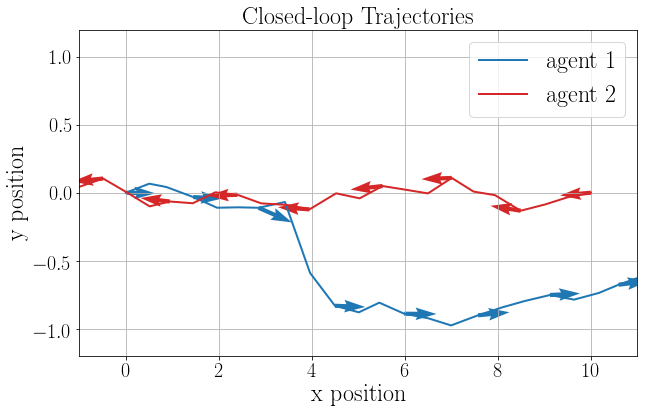

In [7]:
plt.figure(figsize=(10,6))
ax = plt.gca()
plot_trajs(ax, x_1_traj, x_2_traj)
ax.grid()
plt.xlabel("x position")
plt.ylabel("y position")
plt.legend(("agent 1", "agent 2"))
plt.title("Closed-loop Trajectories")

## Sample trajectories and plot

In [8]:
traj_list = []
N_trajs = 200
for _ in range(N_trajs):
    x_1 = np.random.normal(size=2) * sigma_0 + x_init_1
    x_2 = np.random.normal(size=2) * sigma_0 + x_init_2
    trajs = sim_traj(x_1, x_2)
    traj_list.append(trajs)
    

Text(0.5,1,'Sampled Reachable Sets')

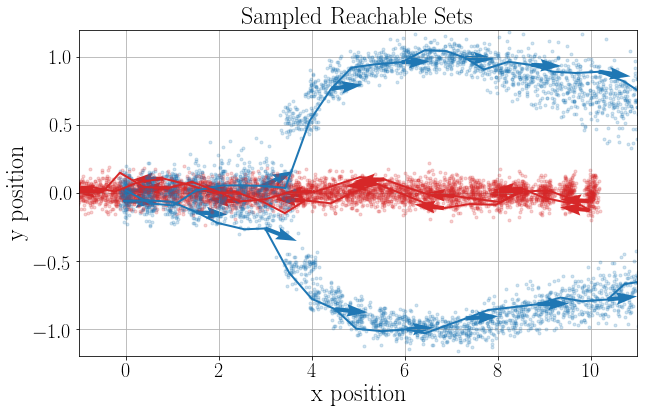

In [9]:
plt.figure(figsize=(10,6))
ax = plt.gca()
for trajs in traj_list:
    plot_trajs(ax, *trajs, alpha=.2, quiver=False, ls=".")
ax.grid() 
plot_trajs(ax, *traj_list[-1])
plot_trajs(ax, *traj_list[-2])
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Sampled Reachable Sets")

In [10]:
x_1_mat = np.array([traj[0] for traj in traj_list])
x_2_mat = np.array([traj[1] for traj in traj_list])

def cluster_points(mat, timestep, n_c=2):
    X = mat[:,timestep,:]
    kmeans = KMeans(n_clusters=n_c, random_state=0).fit(X)
    return tuple(X[kmeans.labels_==i, :] for i in range(n_c))

def compute_polytope(points):
    return polytope.qhull(points)

def kmeans_randup(mat, n_c=2):
    return [[compute_polytope(points) for points in cluster_points(mat, t, n_c=n_c)]for t in range(mat.shape[1])]

def polytope_unions_intersect(polytopes_1, polytopes_2):
    return np.any([not polytope.is_empty(p1.intersect(p2)) for p1,p2 in itertools.product(polytopes_1, polytopes_2)])

def is_safe_tubes(reach_sets_1, reach_sets_2):
    return np.any([polytope_unions_intersect(ps_1, ps_2) for ps_1, ps_2 in zip(reach_sets_1, reach_sets_2)])

In [11]:
reach_sets_naive = kmeans_randup(x_1_mat, n_c=1)
reach_sets_kmeans = kmeans_randup(x_1_mat, n_c=2)
reach_sets_2 = kmeans_randup(x_2_mat, n_c=1)

intersects_naive = is_safe_tubes(reach_sets_naive, reach_sets_2)
intersects_kmeans = is_safe_tubes(reach_sets_kmeans, reach_sets_2)

print("Naive RandUp Certifies The Policies as " + ("unsafe" if intersects_naive else "safe"))
print("K-means RandUp Certifies The Policies as " + ("unsafe" if intersects_kmeans else "safe"))

Naive RandUp Certifies The Policies as unsafe
K-means RandUp Certifies The Policies as safe


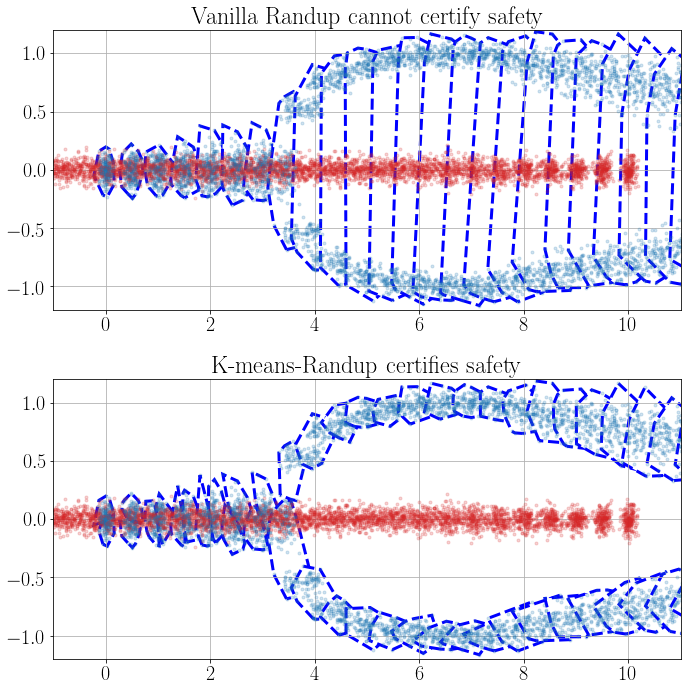

In [12]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
for ax in axs:
    for trajs in traj_list:
        plot_trajs(ax, *trajs, alpha=.2, quiver=False, ls=".")
    ax.grid()

title_strings = ("Vanilla Randup cannot certify safety", "K-means-Randup certifies safety")

for i, ax in enumerate(axs):
    reach_sets = kmeans_randup(x_1_mat, n_c=i+1)
    for polytopes in reach_sets:
        for p in polytopes:
            p.plot(ax=ax, alpha=1, color="w", edgecolor="blue")
    ax.title.set_text(title_strings[i])

plt.tight_layout()